# KMeans clustering of VGG embeddings

In [1]:
%load_ext autoreload
%autoreload 2

%env CUDA_VISIBLE_DEVICES 5

env: CUDA_VISIBLE_DEVICES=5


Meh, imports.

In [2]:
import sys

sys.path.insert(0, '../batchflow')
sys.path.insert(0, '../src')

import numpy as np
import pandas as pd
from skimage.transform import resize
from matplotlib.pyplot import get_cmap
from matplotlib.colors import ListedColormap

from batchflow import Pipeline, B, V, I, M, C, plot
from batchflow.models.torch import TorchModel, VGGBlock
from batchflow.models.metrics import ClassificationMetrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from nbtools.core import get_notebook_name

from loader import ImagesDataset
from evaluator import MetricsEvaluator

Experiment name.

In [120]:
NAME = get_notebook_name()
NAME

'03_VGG+KMEANS'

Seed fix.

In [29]:
SEED = 11
rng = np.random.default_rng(SEED)

Load data.

In [5]:
DATA_PATH = '../images'
SHAPE = (128, 128, 3)

dataset = ImagesDataset(path=DATA_PATH, encode_labels=True, normalize=(0, 255), resize_shape=SHAPE)
dataset.split(shuffle=SEED)

train_uniques, train_counts = np.unique(dataset.labels[dataset.train.indices], return_counts=True)
train_shares = train_counts / train_counts.sum()

100%|█████████████████████████████████████████████| 9/9 [00:17<00:00,  1.96s/it]


Load trained model.

In [6]:
MODEL_PATH = '../models/02_VGG_OLD.torch'
model = TorchModel()
model.load(MODEL_PATH)
penultimate_module = model.model[1][-2]

Define inference pipeline with additional action for penultimate layer activations extration via a forward hook registered for corresponding model module.

In [7]:
%%time

predict_template = (
    Pipeline()
    # prepare data
    .to_array(channels='first', dtype=np.float32)
    
    # import trained model
    .import_model('model', model)
    
    # make predictions
    .predict_model(
        name='model', inputs=B('images'),
        outputs=['predictions', 'predicted_proba'],
        save_to=[B('predictions'), B('proba')]
    )
    
    # get penultimate layer activations
    .call(model.get_intermediate_activations, inputs=B('images'),
          layers=penultimate_module, save_to=B('activations'))
)

predict_pipeline_train = predict_template << dataset.train
train_batch = predict_pipeline_train.next_batch(dataset.train.size)
dataset.activations = train_batch.activations

CPU times: user 798 ms, sys: 1.01 s, total: 1.8 s
Wall time: 8.38 s


Usefull utils and convinient colormap (transparent on small values, almost opaque on big).

In [8]:
def normalize_min_max(arr):
    min_, max_ = np.min(arr), np.max(arr)
    res = (arr - min_) / (max_ - min_)
    return res

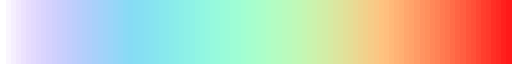

In [9]:
domain = np.linspace(0, 1, 100, endpoint=True)
cam_clist = get_cmap('rainbow')(domain)

eps = 0.1
opacity = normalize_min_max(np.log(domain + eps)) * 0.9
cam_clist[:, 3] = opacity
cam_cmap = ListedColormap(cam_clist, 'CAM')
cam_cmap

Let's re-weight penultimate layer activations by gradients of last model layer with respect to those layers parameters.
That called Grad-CAM, meaning gradient [corrected] class activation map. It should (in theory) highlight regions of activations (that somehow in spatial sence correspond model inputs), that influence final class score the most.

However, it's not always easy to interpret those maps. For example, it's rather clear that for Rococo detection model tends to look for face parts, for Impressionism — on horizon line, on Realism — leaves and flowers, for Japonism — on hieroglyphs. But what's going on with our poor ArtDeco? No idea. Cubism is probably triggered by a dense mixture of edges and colours, cartoon — by specific 'drawish' contours, photos — probably by rather contrast and sharp edges non-typical for drawings.

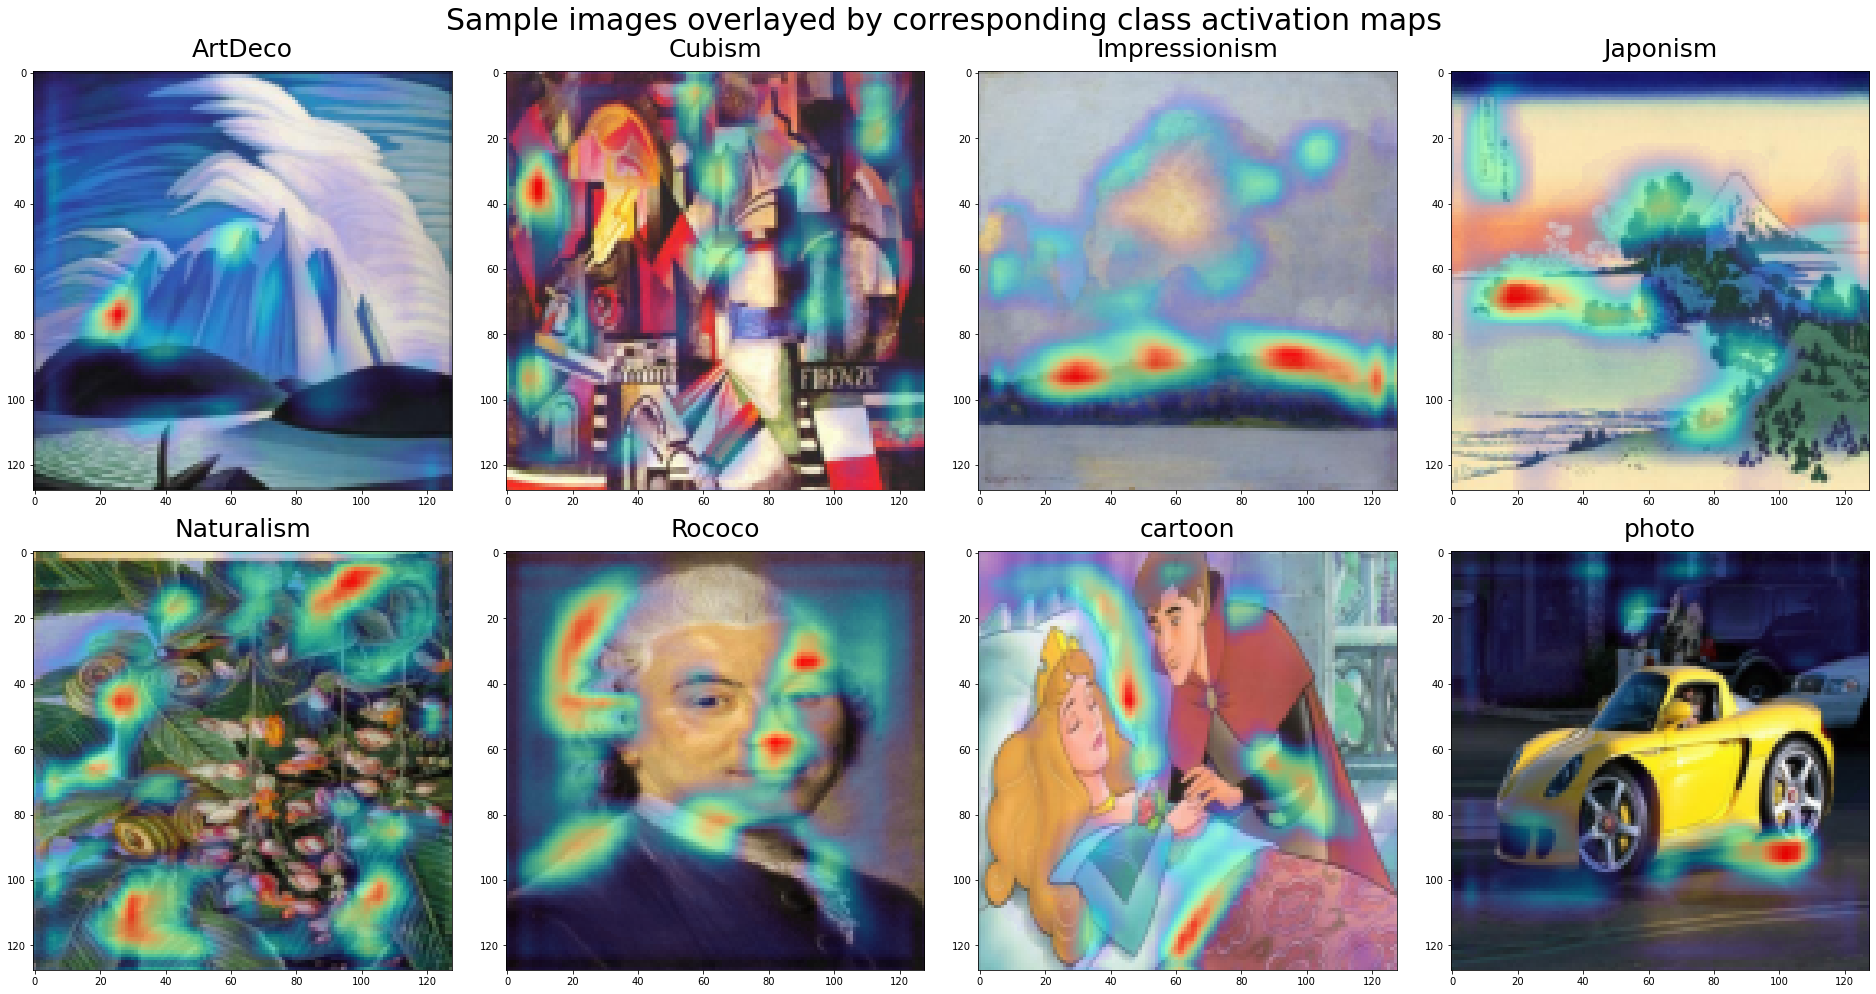

In [30]:
images = []
cams = []
labels = []

samples_indices = [rng.choice(np.nonzero(dataset.labels[dataset.test.indices] == label)[0]) for label in range(dataset.n_classes)]
for index in samples_indices:
    image = dataset.images[dataset.test.indices][index]
    # images.append(dataset.denormalize_image(image)) # nevermind
    images.append(image)

    image_ = image.transpose(2, 0, 1)[None, ...]
    cam = model.get_gradcam(inputs=image_, layer=penultimate_module)
    cam = resize(cam, image.shape[:2])
    cams.append(cam)

    label = dataset.labels[dataset.test.indices][index]
    labels.append(label)

labels = dataset.label_encoder.inverse_transform(labels).tolist()

# plot(images, combine='separate', title=labels, suptitle='Images', suptitle_size=30)
# plot(cams, combine='separate', cmap='rainbow', title=labels, suptitle='Class activation maps', suptitle_size=30)

pairs = [[image, cam] for image, cam in zip(images, cams)]
plot(pairs, cmap=cam_cmap, title=labels, suptitle='Sample images overlayed by corresponding class activation maps', suptitle_size=30)

Time to move on to clusterig. But first let's reduce a bit dimensionality of our data. Say, from 262144 to 100 features. PCA serves.

In [ ]:
%%time

n_features = 100
pca = PCA(n_components=n_features, random_state=SEED)
train_features = train_batch.activations.reshape(dataset.train.size, -1)
train_features_reduced = pca.fit_transform(train_features)

Without much thought, try KMeans.

In [12]:
%%time

clusterer = KMeans(n_clusters=dataset.n_classes, random_state=SEED)
train_clustered = clusterer.fit_predict(train_features_reduced)

CPU times: user 1.71 s, sys: 8.04 s, total: 9.75 s
Wall time: 149 ms


A couple of clustering metrics invariant to class labels permutations tell us, that train data is clustered perfectly.

In [13]:
train_targets = train_batch.labels
train_predictions = np.argmax(train_batch.predictions, axis=1)
classification_evaluator = MetricsEvaluator(targets=train_targets, predictions=train_predictions, classes=dataset.classes)
classification_evaluator = classification_evaluator.evaluate_clustering_metrics()

,adjusted_rand_score,adjusted_mutual_info_score
0,100.0,100.0


In [14]:
clustering_evaluator = MetricsEvaluator(targets=train_targets, predictions=train_clustered, classes=dataset.classes)
clustering_metrics = clustering_evaluator.evaluate_clustering_metrics()

,adjusted_rand_score,adjusted_mutual_info_score
0,100.0,100.0


Since all train samples fall perfectly in separate clusters, it's easy to renumerate them since we know the original labels. That'll help us evaluate clustered test data.

In [15]:
cluster_to_class = {}

for cluster_num in range(dataset.n_classes):
    cluster_classes = train_targets[train_clustered == cluster_num]
    classes_count = np.bincount(cluster_classes, minlength=dataset.n_classes)
    
    best_candidate = np.argmax(classes_count)
    cluster_to_class[cluster_num] = best_candidate

    classes_count_repr = ' '.join(str(item).rjust(3, ' ') for item in classes_count)
    print(f"cluster {cluster_num}: [{classes_count_repr}] -> best candidate class: {best_candidate}")

cluster 0: [  0   0   0   0 173   0   0   0] -> best candidate class: 4
cluster 1: [  0   0   0   0   0   0  56   0] -> best candidate class: 6
cluster 2: [  0   0 194   0   0   0   0   0] -> best candidate class: 2
cluster 3: [  0   0   0 161   0   0   0   0] -> best candidate class: 3
cluster 4: [  0   0   0   0   0   0   0 110] -> best candidate class: 7
cluster 5: [  0 293   0   0   0   0   0   0] -> best candidate class: 1
cluster 6: [  0   0   0   0   0  98   0   0] -> best candidate class: 5
cluster 7: [ 53   0   0   0   0   0   0   0] -> best candidate class: 0


Following the pipeline described above (penultimate layer activations —> dimensionality reduction -> clustering -> renumeration) let get predictions.

In [ ]:
%%time

predict_pipeline_test = predict_template << dataset.test
test_batch = predict_pipeline_test.next_batch(dataset.test.size)

test_features = test_batch.activations.reshape(dataset.test.size, -1)
test_features_reduced = pca.transform(test_features)

test_clustered = clusterer.predict(test_features_reduced)

test_targets = test_batch.labels
test_predictions = np.argmax(test_batch.predictions, axis=1)

First, evaluate them via clustering permutation-insensible metrics. Not perfect, but ok.

In [16]:
clustering_evaluator = MetricsEvaluator(targets=test_targets, predictions=test_clustered, classes=dataset.classes)
clustering_metrics = clustering_evaluator.evaluate_clustering_metrics()

,adjusted_rand_score,adjusted_mutual_info_score
0,41.2,41.7


CPU times: user 6.93 s, sys: 2.58 s, total: 9.51 s
Wall time: 2.56 s


Now, how about classification metrics for renumerated clusters? And that is actually pretty good! It's even a bit better than original VGG7 classification. 

,shares,precision,recall
ArtDeco,4.7,66.7,50.0
Cubism,25.7,72.5,80.6
Impressionism,17.0,57.1,69.6
Japonism,14.1,74.2,54.8
Naturalism,15.2,78.9,66.7
Rococo,8.6,48.3,73.7
cartoon,4.9,72.7,42.1
photo,9.7,66.7,69.0


,accuracy,f1_score
altogether,67.3,65.2


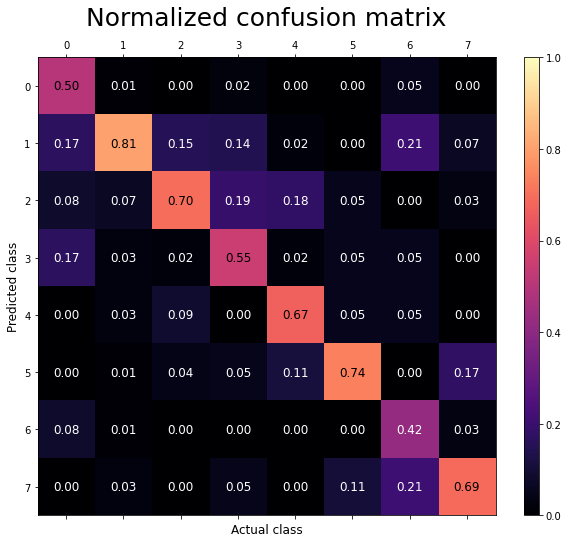

In [17]:
METRICS_PATH = f'../metrics/{NAME}.json'

test_clustered_renumerated = np.array(list(map(cluster_to_class.__getitem__, test_clustered)))
evaluator = MetricsEvaluator(targets=test_targets, predictions=test_clustered_renumerated, classes=dataset.classes, shares=train_shares)
metrics_dict = evaluator.evaluate_classification_metrics(show=True, savepath=METRICS_PATH)

So, is there something special about those clusters? And is there a way to analyse, how our multi-step algorithm decides which class to assign to given image? Well, maybe. Let's implement sort of Grad-CAM, but for clustering. Since there are no gradient to use for activation tensor weighting, let do the following:
- calculate the difference between sample feature vector and corresponding cluster center
- inverse transform it through reverse pca to original basis
- min-max normalize it and mutiply element-wise with original activation tensor (also min-max normalized)
- overlay one over another
- ?????
- PROFIT

Let's name it Diff-CAM :)

...

Well, on results interpretation. Highlighted images areas are kinda similar to those shown by Grad-CAM and that's not surprising at all. After all, there are the same activation maps underneath, just weighted a bit differently. But, even taking in account the normalization we used in Diff-CAM calculation (that affect mean values of resulting map and therefore leads to opacity shift compared to origin Grad-CAM), there is one notable fact those activations, that probably explains a slightly better generalization capability of clustering approach itself:

Highlighted by Diff-CAM areas on sample images are of the same kind (more flowers in Naturalism, longer horizon line in Impressionism etc.) as on Grad-CAM, but <u>there are more of them</u>, as if KMeans is just taking more aspects into account, than a fully connected layer at the end of VGG network does.

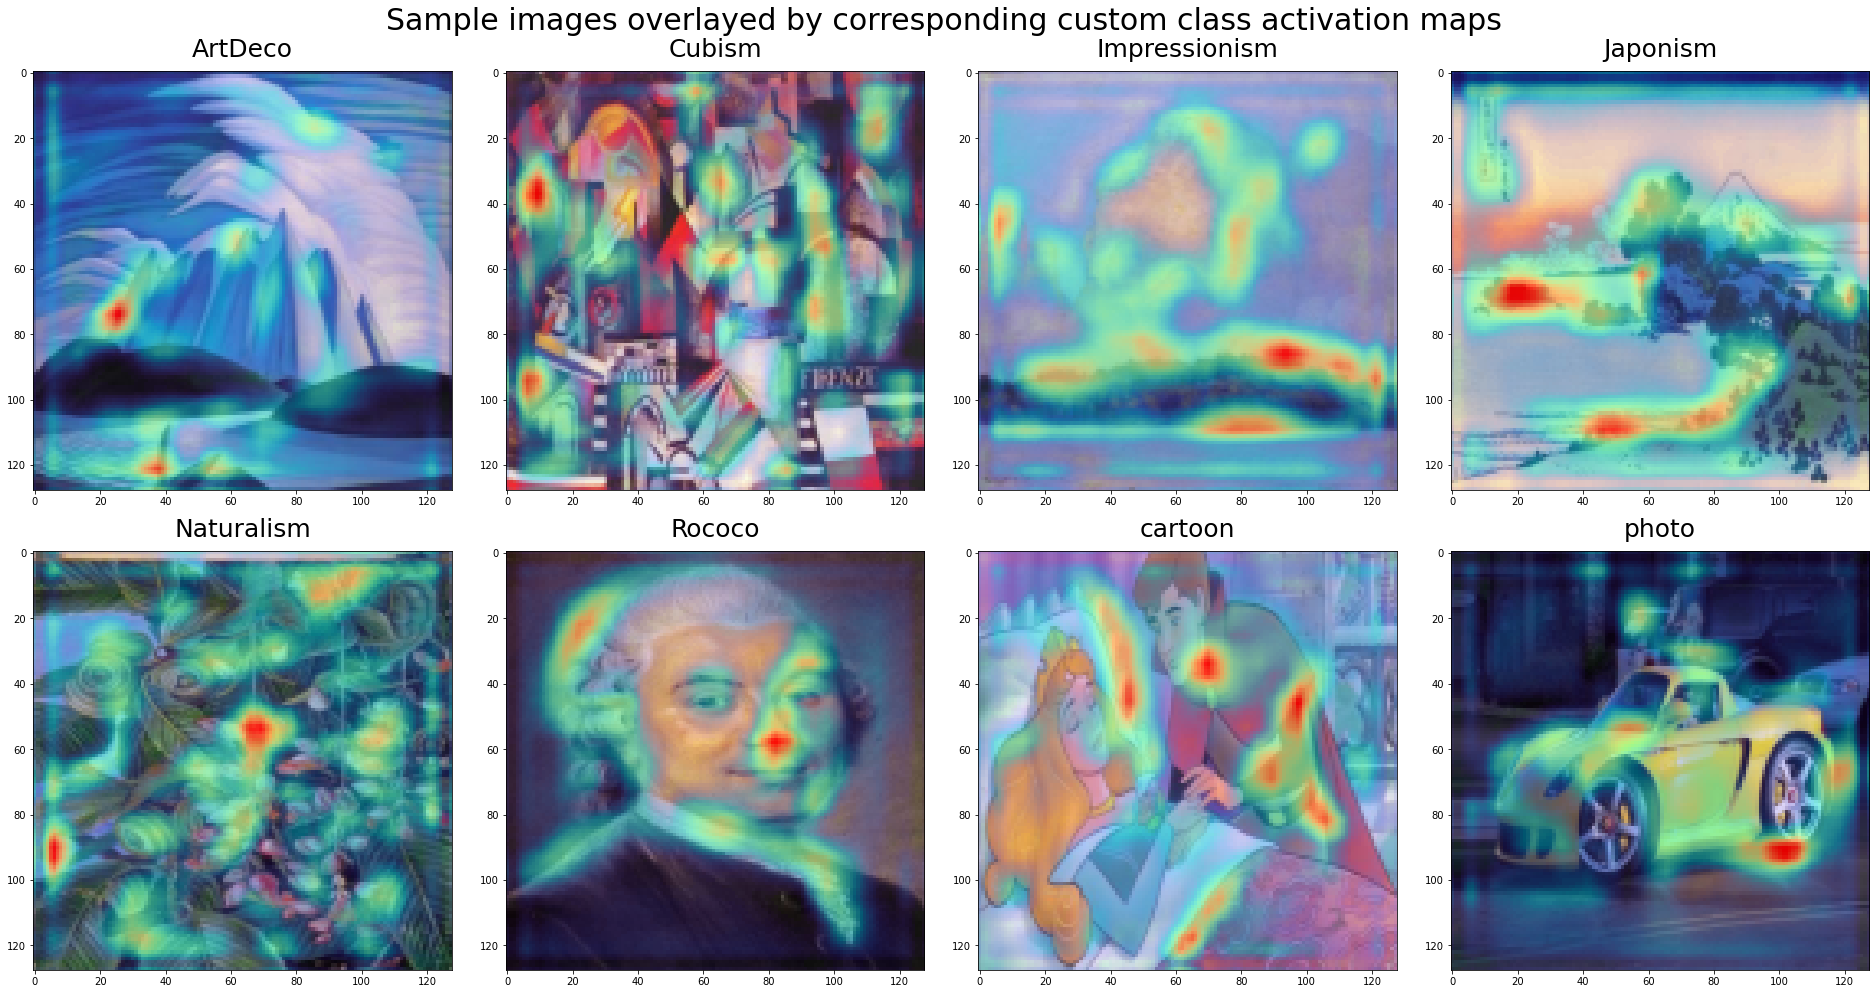

In [34]:
class_to_cluster = {value: key for key, value in cluster_to_class.items()}

images = []
cams = []

for index in samples_indices:
    image = test_batch.images[index].transpose(1, 2, 0)
    # images.append(dataset.denormalize_image(image)) # nevermind №2
    images.append(image)

    feature = test_features_reduced[index]
    label = test_targets[index]
    cluster = test_clustered[class_to_cluster[label]]
    center = clusterer.cluster_centers_[cluster]

    diff = np.abs(center - feature)
    diff_full = pca.inverse_transform(diff)
    diff_full = normalize_min_max(diff_full)

    activation = test_batch.activations[index]
    activation = normalize_min_max(activation)
    diff_2d = diff_full.reshape(activation.shape)

    cam = activation * diff_2d
    cam = normalize_min_max(cam)
    cam_reduced = cam.mean(axis=0)
    cam_upsampled = resize(cam_reduced, image.shape[:2])
    cams.append(cam_upsampled)

# plot(images, combine='separate')
# plot(cams, combine='separate', cmap='rainbow')
pairs = [[image, cam] for image, cam in zip(images, cams)]
plot(pairs, title=dataset.classes, cmap=cam_cmap, suptitle='Sample images overlayed by corresponding custom class activation maps', suptitle_size=30)

And, talking about clusters and how are they different from each other. We might compare their averaged centroids mapped back into penultimate layer activation space.

The first thing that catches ones eye, is that there are borders on every one of those maps. That's probably due to irregular canvas forms of many samples, containing almost none useful info.

Another interesting fact, is that there are notable specific macro-shapes on centroids projections of ArtDeco, Rococo and photo classes. That's probably also a consequence of style-specific object-on-canvas placement. There are some samples in ArtDeco class that mainly occupy the center image area with constant background everywhere else. Rococo is famous for it's round portraits with a face of person in the center (see that saturated green area?). Finally, the photo class has by it's nature almost none specific macrostructure, meaning that the objects of various forms and shapes might be in every part of the image and that assumption perfectly corresponds that almost fully-filled with intense green color class centroid map.

As for other styles, they seem to lack such features and more specific local ones are lost during across-channel averaging.

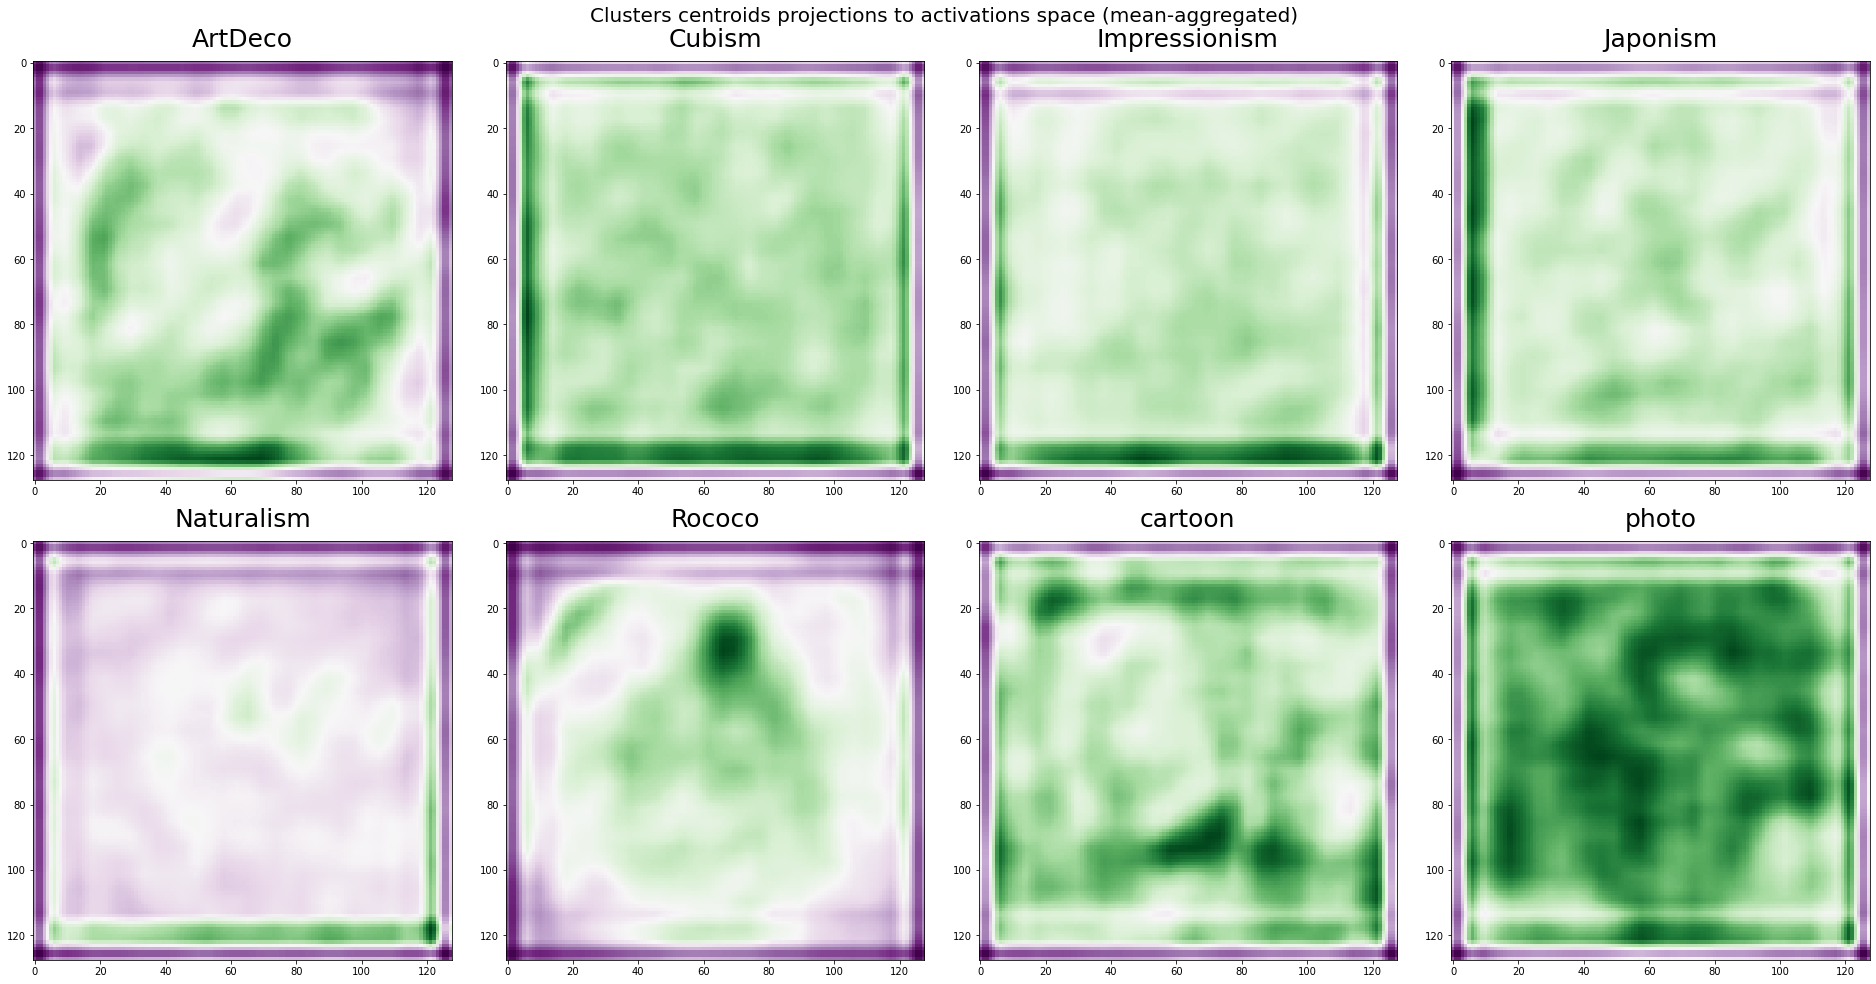

In [39]:
mean_centers = []

for class_num in range(dataset.n_classes):
    cluster_num = class_to_cluster[class_num]
    center = clusterer.cluster_centers_[cluster_num]
    full_center = pca.inverse_transform(center)
    full_center = full_center.reshape(256, 32, 32)

    mean_center = full_center.mean(axis=0)
    mean_center_upsampled = resize(mean_center, (128, 128))
    mean_centers.append(mean_center_upsampled)

plot(mean_centers, combine='separate', title=dataset.classes, cmap='PRGn', suptitle='Clusters centroids projections to activations space (mean-aggregated)')

In [67]:
import matplotlib.pyplot as plt

In [68]:
pca_3d = PCA(3)
train_3d = pca_3d.fit_transform(train_features_reduced)
centers_3d = pca_3d.transform(clusterer.cluster_centers_)

In [70]:
from batchflow.plotter.plot import Subplot

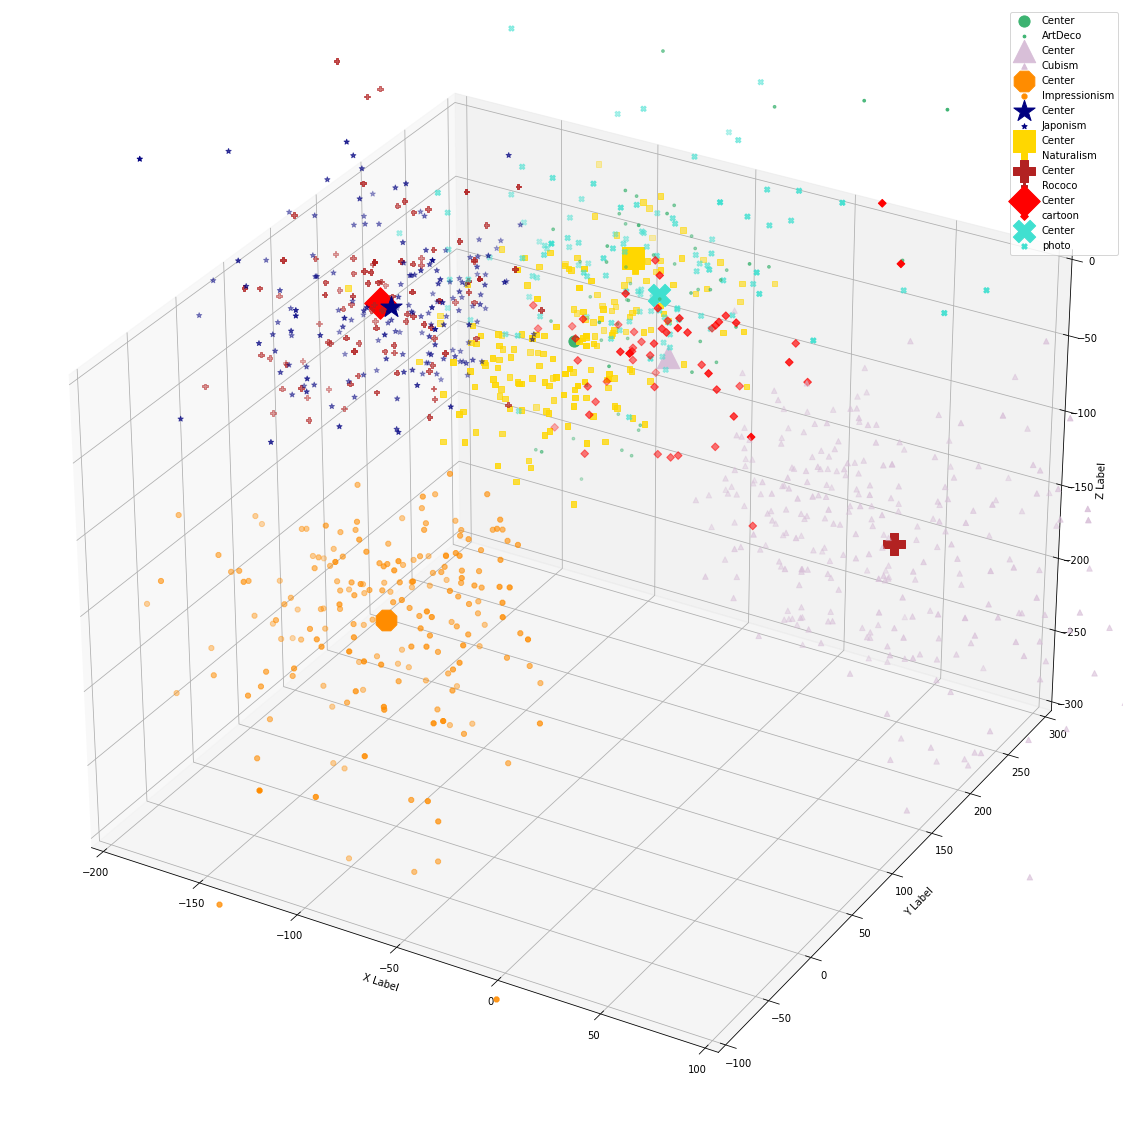

In [115]:
fig = plt.figure(figsize=(20, 30))
ax = fig.add_subplot(projection='3d')

markers = ['.', '^', '8', '*', 's', 'P', 'D', 'X']
center_size = 500
common_size = 30
for index in range(dataset.n_classes):
    center = centers_3d[index]
    color = Subplot.MASK_COLORS[index]
    ax.scatter(*center, c=color, s=center_size, marker=markers[index])
    samples = train_3d[train_targets == index]
    ax.scatter(*samples.T, c=color, s=common_size, marker=markers[index])

ax.set_xlim(-200, 100)
ax.set_ylim(-100, 300)
ax.set_zlim(-300, 0)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

legend_labels = sum([['Center', class_] for class_ in dataset.classes], [])
ax.legend(legend_labels)
plt.show()

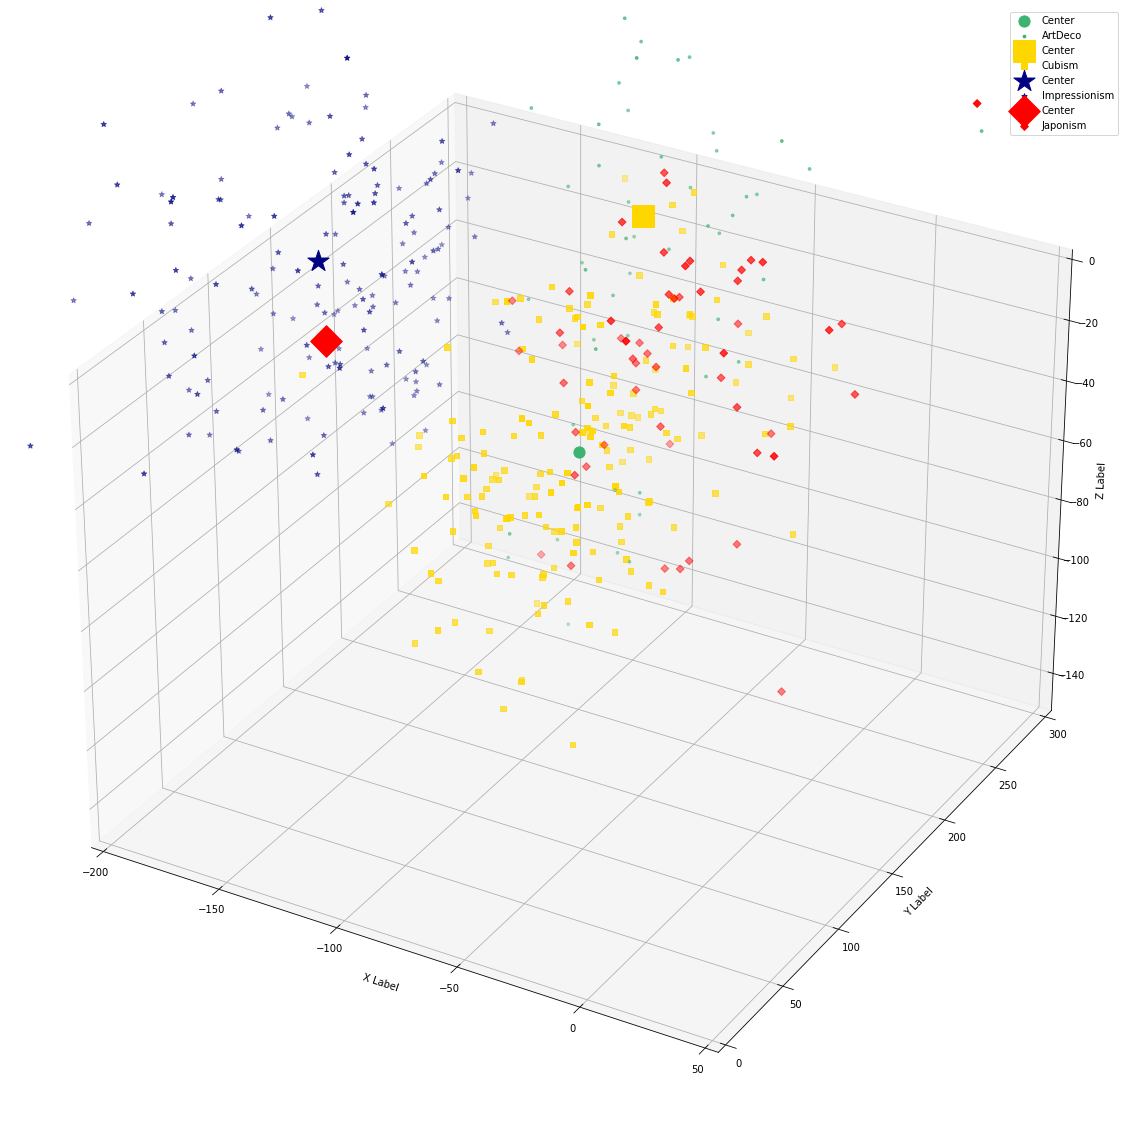

In [119]:
fig = plt.figure(figsize=(20, 30))
ax = fig.add_subplot(projection='3d')

markers = ['.', '^', '8', '*', 's', 'P', 'D', 'X']
center_size = 500
common_size = 30

indices = [dataset.classes.index(style) for style in ['ArtDeco', 'Naturalism', 'Japonism', 'cartoon']]
for index in indices:
    center = centers_3d[index]
    color = Subplot.MASK_COLORS[index]
    ax.scatter(*center, c=color, s=center_size, marker=markers[index])
    samples = train_3d[train_targets == index]
    ax.scatter(*samples.T, c=color, s=common_size, marker=markers[index])

ax.set_xlim(-200, 50)
ax.set_ylim(0, 300)
ax.set_zlim(-150, 0)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

legend_labels = sum([['Center', class_] for class_ in dataset.classes], [])
ax.legend(legend_labels)
plt.show()